In [1]:
setwd("/mnt/10/yuan_jianwen/cRBP/05.splicing/04.shRNA/04.rmats_rmdup_results/")

In [17]:
source("/home/yuan_jianwen/script/myfunction.R")
library(pheatmap)
library(ggplot2)
library(parallel)
library(universalmotif)
library(motifStack)


In [3]:

known_motif_enrich_file <- Sys.glob("shIGF2BP1_rmdup/*.flank300bp.bgh*7mer/ame_out_homerfabg_fisher/ame.tsv")
known_motif_enrich_file

[1] "shIGF2BP1_rmdup/SE.MATS.JC.sig.flank300bp.bghg38r.motif.7mer/ame_out_homerfabg_fisher/ame.tsv"

In [4]:
motif_p <- fread(known_motif_enrich_file)[,c(3,5,7)] %>% mutate(sample = "IGF2BP1") %>% cn(3, "adj_p") %>%mutate(adj_p = -log10(adj_p))
head(motif_p)

Warning message in fread(known_motif_enrich_file):
“Stopped early on line 128. Expected 17 fields but found 0. Consider fill=TRUE and comment.char=. First discarded non-empty line: <<# AME (Analysis of Motif Enrichment): Version 5.5.2 compiled on Apr 10 2023 at 13:51:35>>”


motif_ID,consensus,adj_p,sample
<chr>,<chr>,<dbl>,<chr>
Tbg97262300_7mer_logoM190,CUKUUGU,40.18509,IGF2BP1
SFPQ_7mer_logoM168,GURGUKU,27.75449,IGF2BP1
RALYL_7mer_logo0,UUUNUUU,26.86328,IGF2BP1
BOLL_7mer_logo1,UGUGUUN,24.42597,IGF2BP1
DAZ3_7mer_logo1,GUUUUUU,23.53760,IGF2BP1
CELF1_7mer_logo1,GUCUUGU,23.38091,IGF2BP1


In [46]:
motif_reduce <- mutate(motif_p, rbp = gsub("_7mer.*.", "", motif_ID)) %>%
        subset(adj_p >= 3)  %>% spread(sample, adj_p, fill = 0) %>% 
        group_by(rbp) %>%top_n(1, IGF2BP1)
head(motif_reduce)

motif_ID,consensus,rbp,IGF2BP1
<chr>,<chr>,<chr>,<dbl>
aret_7mer_logoM003,UGUGUGU,aret,13.386158
aretCONSTRUCT_7mer_logoM229,UKUGUGU,aretCONSTRUCT,12.097453
AT1G76460TAIRG_7mer_logoM239,RGUGUGA,AT1G76460TAIRG,4.860121
BOLL_7mer_logo1,UGUGUUN,BOLL,24.425969
bru3_7mer_logoM117,GUGGUGU,bru3,9.860121
BRUNOL4_7mer_logoM004,UGUGUGU,BRUNOL4,22.591760


In [47]:
### IGF2BP1 interatome data from MS 
igf2bp1_ms_data <- read.csv("igf2bp1_interaction.csv")
head(igf2bp1_ms_data)

,name,type
,<chr>,<chr>
1,HNRNPR,RNAse_dependent_interaction
2,IGF2BP2,RNAse_dependent_interaction
3,IGF2BP3,RNAse_dependent_interaction
4,YBX3,RNAse_dependent_interaction
5,PURA,RNAse_dependent_interaction
6,PABPC1,RNAse_dependent_interaction


In [58]:
motif_reduce %<>% merge(.,igf2bp1_ms_data, by.x = "rbp", by.y = "name")

In [40]:
### plot motif cluster 

In [59]:
### RBP PWMs from oRNAment database
motif_files <- Sys.glob("PWMs/*motif")
names(motif_files) <- basename(motif_files) %>% gsub(".motif", "", .)
motif_files <- motif_files[motif_reduce$motif_ID ]

In [61]:
motif_list <- mclapply(motif_files, function(x){
    mm <- read_homer(x)@motif
    rownames(mm)[4] <- "U"
    mm
})

In [62]:
names(motif_list) %<>% gsub("7mer_logo", "", .)

In [63]:
hc <- clusterMotifs(motif_list, revcomp=FALSE)
phylog <- ade4::hclust2phylog(hc)

leaves <- names(phylog$leaves)
pfms <- motif_list[leaves]
pfms <- mapply(pfms, names(pfms), FUN=function(.ele, .name){
             new("pfm",mat=.ele, name=.name)})
pfms <- DNAmotifAlignment(pfms, minimalConsensus=3)

The input is RNA motif. 
            The reverse complementation alignment will be turn off.
            To avoid this message, please set revcomp=rep(FALSE, length(pfms))



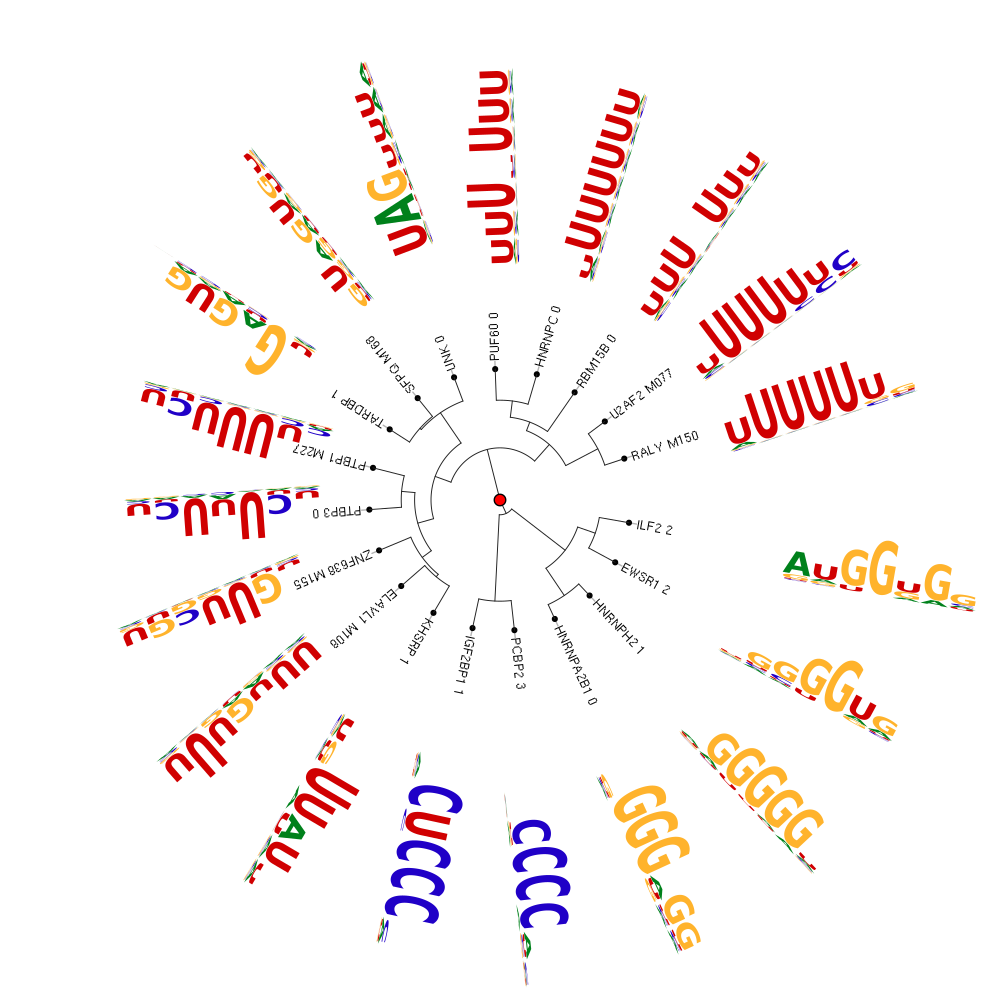

In [33]:
options(repr.plot.width =10, repr.plot.height =10, repr.plot.res = 100)
motifStack(pfms, layout="radialPhylog",
           circle=0.9, 
           cleaves = 0.5, clabel.leaves = 0.7, 
           inner.label.circle.width=2,
           outer.label.circle.width=0.1,
           circle.motif=1.2,
           angle=350)

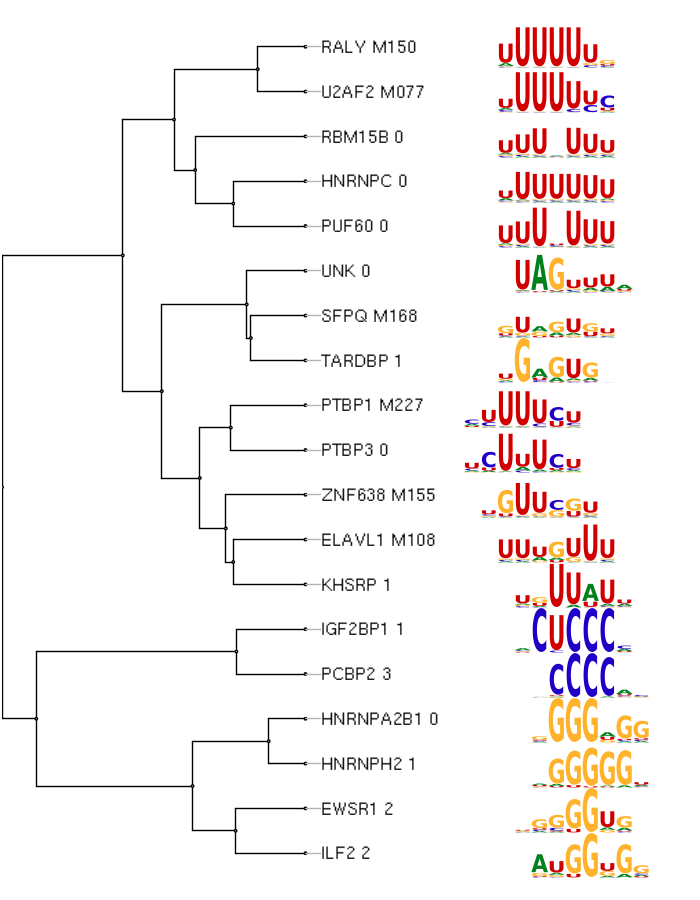

In [34]:

options(repr.plot.width =7, repr.plot.height =9, repr.plot.res = 100)
motifPiles(phylog, pfms) 
